# Unsupervised Anomaly Detection

Anomaly detection detects data points in data that does not fit well with the rest of data. In this notebook we demonstrate how to do anomaly detection for 1-D data using Chronos's dbscan detector, autoencoder detector and threshold detector.

For demonstration, we use the publicly available cluster trace data cluster-trace-v2018 of Alibaba Open Cluster Trace Program. You can find the dataset introduction <a href="https://github.com/alibaba/clusterdata/blob/master/cluster-trace-v2018/trace_2018.md" target="_blank">here</a>. In particular, we use machine usage data to demonstrate anomaly detection, you can download the separate data file directly with <a href="http://clusterdata2018pubcn.oss-cn-beijing.aliyuncs.com/machine_usage.tar.gz" target="_blank">machine_usage</a>.

## Download raw dataset and load into dataframe

Now we download the dataset and load it into a pandas dataframe.Steps are as below:
* First, download the raw data <a href="http://clusterdata2018pubcn.oss-cn-beijing.aliyuncs.com/machine_usage.tar.gz" target="_blank">machine_usage</a>. Or run the script `get_data.sh` to download the raw data.It will download the resource usage of each machine from m_1932 to m_2085. 
* Second, run `grep m_1932 machine_usage.csv > m_1932.csv` to extract records of machine 1932. Or run `extract_data.sh`.We use machine 1932 as an example in this notebook.You can choose any machines in the similar way.
* Finally, use pandas to load `m_1932.csv` into a dataframe as shown below.

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_1932 = pd.read_csv("m_1932.csv", header=None, usecols=[1,2,3], names=["time_step", "cpu_usage","mem_usage"])

Below are some example records of the data

In [3]:
df_1932.head()

,time_step,cpu_usage,mem_usage
0,386640,41,92
1,386670,43,92
2,386690,44,92
3,386800,46,92
4,386930,44,93


<AxesSubplot:title={'center':'cpu_usage of machine 1932'}, xlabel='time_step'>

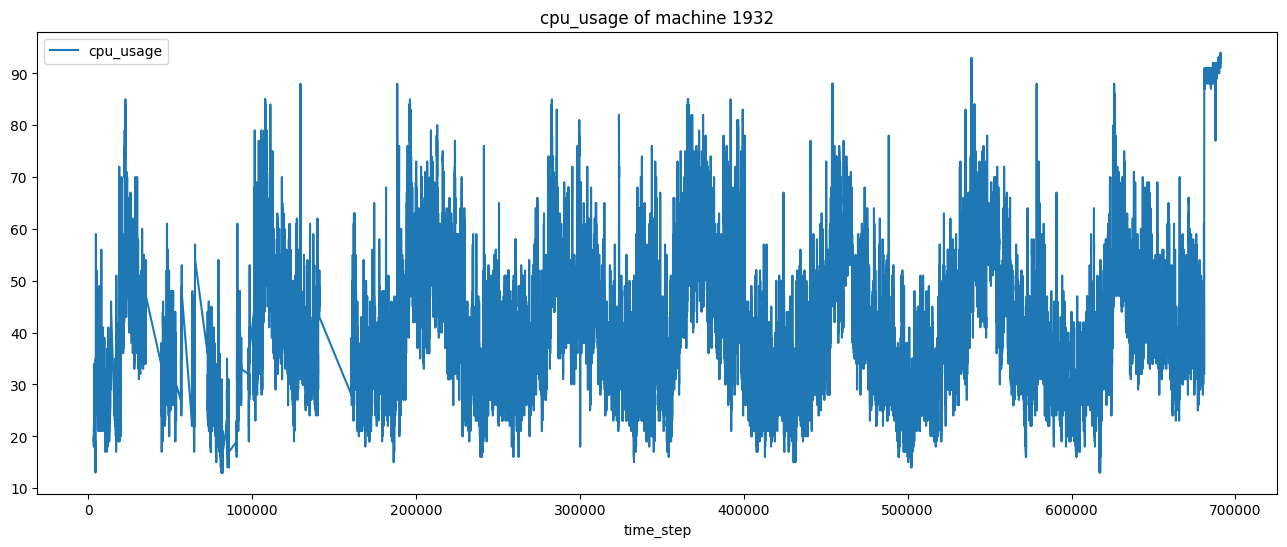

In [4]:
df_1932.sort_values(by="time_step", inplace=True)
df_1932.reset_index(inplace=True)
df_1932.plot(y="cpu_usage", x="time_step", figsize=(16,6),title="cpu_usage of machine 1932")

## Data pre-processing

Now we need to do data cleaning and preprocessing on the raw data. Note that this part could vary for different dataset. 

For the machine_usage data, the pre-processing contains 2 parts:
1. Convert the time step in seconds to timestamp starting from 2018-01-01
2. Generate a built-in TSDataset to resample the average of cpu_usage in minutes and impute missing data

In [5]:
df_1932["time_step"] = pd.to_datetime(df_1932["time_step"], unit='s', origin=pd.Timestamp('2018-01-01'))

In [6]:
from bigdl.chronos.data import TSDataset

tsdata = TSDataset.from_pandas(df_1932, dt_col="time_step", target_col="cpu_usage")
df = tsdata.resample(interval='1min', merge_mode="mean")\
           .impute(mode="last")\
           .to_pandas()

<AxesSubplot:>

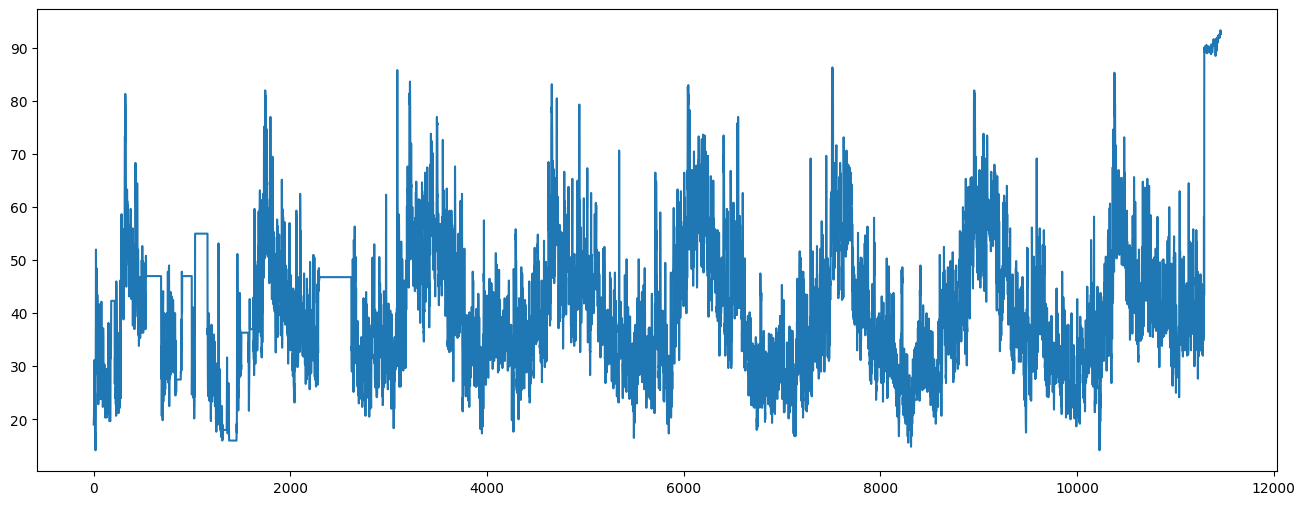

In [7]:
df['cpu_usage'].plot(figsize=(16,6))

## Anomaly Detection by DBScan Detector

DBScanDetector uses DBSCAN clustering for anomaly detection. The DBSCAN algorithm tries to cluster the points and label the points that do not belong to any clusters as -1. It thus detects outliers detection in the input time series. DBScanDetector assigns anomaly score 1 to anomaly samples, and 0 to normal samples.

In [8]:
from bigdl.chronos.detector.anomaly import DBScanDetector

ad = DBScanDetector(eps=0.1, min_samples=6)
ad.fit(df['cpu_usage'].to_numpy())

In [9]:
anomaly_scores = ad.score()
anomaly_indexes = ad.anomaly_indexes()

print("The anomaly scores are:", anomaly_scores)
print("The anomaly indexes are:", anomaly_indexes)

The anomaly scores are: [0. 0. 0. ... 1. 1. 1.]
The anomaly indexes are: [   15    16    17    18   316   317   318   319   321   322   325   326
   425   701  1191  1246  1292  1296  1302  1305  1306  1307  1310  1311
  1312  1360  1362  1366  1374  1455  1732  1733  1743  1744  1745  1746
  1747  1748  1749  1750  1751  1752  1753  1761  1762  1796  1797  1818
  1913  3087  3192  3210  3211  3213  3215  3216  3217  3218  3219  3220
  3227  3228  3276  3392  3429  3434  3435  3438  3448  3488  3489  3490
  3491  3492  3493  3494  3495  3549  3550  3674  3932  3948  4252  4625
  4653  4654  4655  4656  4657  4658  4660  4661  4662  4670  4676  4694
  4709  4710  4936  4937  5019  5342  5343  5493  5848  6039  6040  6041
  6042  6043  6044  6045  6046  6048  6050  6057  6058  6059  6060  6068
  6083  6084  6103  6104  6109  6128  6148  6151  6152  6153  6156  6157
  6183  6184  6185  6197  6212  6218  6223  6224  6246  6247  6404  6405
  6406  6408  6409  6545  6553  6746  7117  7126  7

Draw anomalies in line chart.

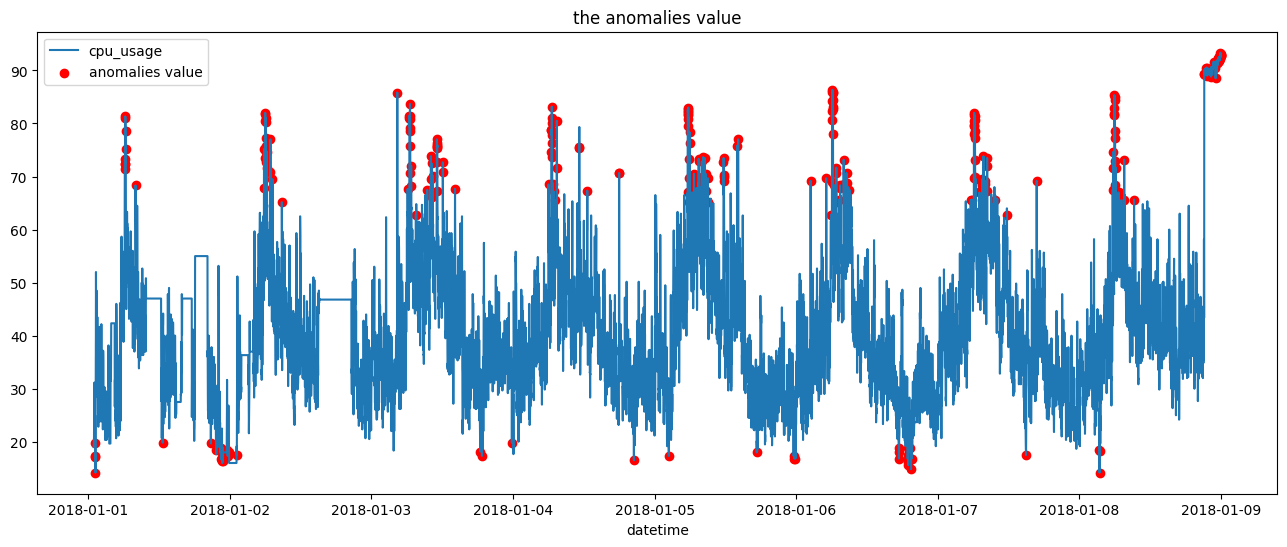

In [10]:
plt.figure(figsize=(16,6))
plt.plot(df.time_step, df.cpu_usage, label='cpu_usage')
plt.scatter(df.time_step[anomaly_indexes], df.cpu_usage[anomaly_indexes], color='red', label='anomalies value')

plt.title('the anomalies value')
plt.xlabel('datetime')
plt.legend(loc='upper left')
plt.show()

## Anomaly Detection by AutoEncoder Detector

AEDetector is unsupervised anomaly detector. It builds an autoencoder network, try to fit the model to the input data, and calcuates the reconstruction error. The samples with larger reconstruction errors are more likely the anomalies.

In [11]:
from bigdl.chronos.detector.anomaly import AEDetector

ad = AEDetector(roll_len=10, ratio=0.05)
ad.fit(df['cpu_usage'].to_numpy())

2023-04-28 09:22:23.732945: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
anomaly_scores = ad.score()
anomaly_indexes = ad.anomaly_indexes()

print("The anomaly scores are:", anomaly_scores)
print("The anomaly indexes are:", anomaly_indexes)

The anomaly scores are: [0.64881897 0.65092546 0.64724153 ... 0.9465837  0.91688025 0.8730135 ]
The anomaly indexes are: [ 9935  1240  8255  9483  6753  8326 10225  7117  9929  9936  3932  1238
   157  1239  8259   133  8563  7130   130  8292  9475  9473  9926   135
  1253 10237  3954  1278  3958  9985  7137  8251   136  1276  7135  8258
  5503  3930  1357  7131 10023 10028  7128  8247  3947  9937 10226  9932
  8250  1242 10232  8301  1370  9476  5848  8257  8295  7133  9934  3950
  6740  9986  9474  8302  8324  5502  1359  1457  7508  1355  9988  6752
  8180  8248  1364  9987    14  9999 10384  3945  8303  1249  3216  3951
  3946  9933  8260  5493  8325  1281  9989  7125  7127  1369  9482  8296
  8253  7132  3957  8252  7510  1358  9990  8274  1245    10  8322  3949
    12  7509  6045  9997  1285  1248  9995  1252  8256  3953  9477  1244
  1363  1284  8293  1250  8273  9998  9994  7136  7126 10235  3956  3952
  8275  6749  8291  1368  8323  1243  1282  8181 10229  9996  6046  9991
  1

Draw anomalies in line chart.

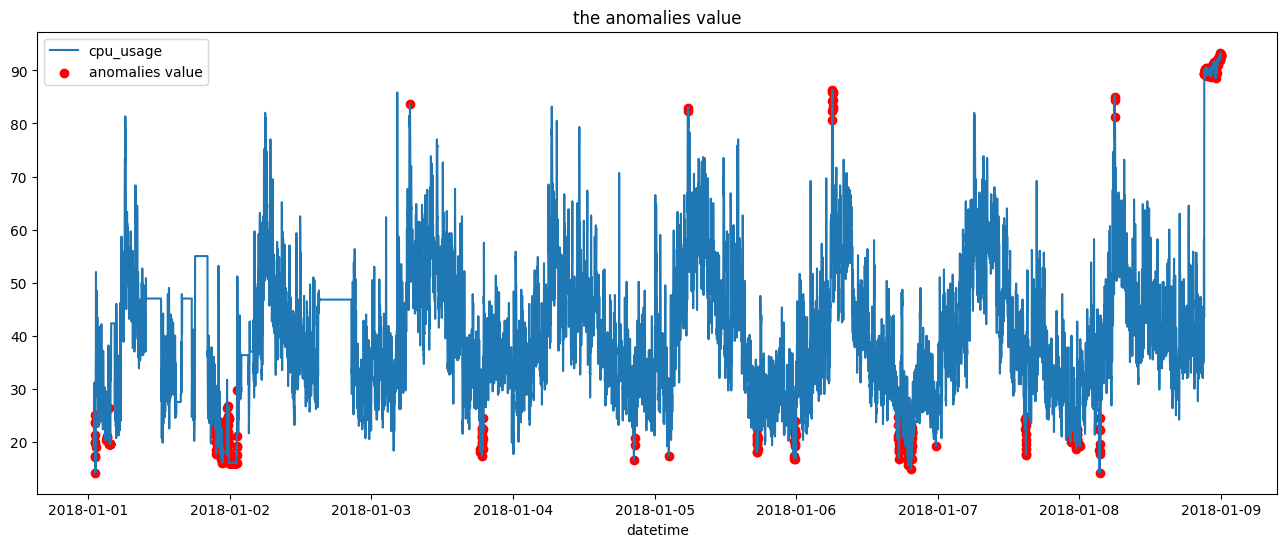

In [13]:
plt.figure(figsize=(16,6))
plt.plot(df.time_step, df.cpu_usage, label='cpu_usage')
plt.scatter(df.time_step[anomaly_indexes], df.cpu_usage[anomaly_indexes], color='red', label='anomalies value')

plt.title('the anomalies value')
plt.xlabel('datetime')
plt.legend(loc='upper left')
plt.show()

## Anomaly Detection by Threshold Detector

ThresholdDetector is a simple anomaly detector that detectes anomalies based on threshold. The target value for anomaly testing can be either 1) the sample value itself or 2) the difference between the forecasted value and the actual value. In this notebook we demostrate the first type. The thresold can be set by user or esitmated from the train data accoring to anomaly ratio and statistical distributions.

In [14]:
from bigdl.chronos.detector.anomaly import ThresholdDetector

thd=ThresholdDetector()
thd.set_params(trend_threshold=(20, 80))
thd.fit(df['cpu_usage'].to_numpy())

In [17]:
anomaly_scores = thd.score()
anomaly_indexes = thd.anomaly_indexes()

print("The anomaly scores are:", anomaly_scores)
print("The anomaly indexes are:", anomaly_indexes)
anomaly_indexes = anomaly_indexes['anomaly index']

The anomaly scores are: {'pattern anomaly score': array([0., 0., 0., ..., 0., 0., 0.]), 'trend anomaly score': array([1., 1., 1., ..., 1., 1., 1.]), 'anomaly score': array([1., 1., 1., ..., 1., 1., 1.])}
The anomaly indexes are: {'pattern anomaly index': [], 'trend anomaly index': [0, 1, 2, 15, 16, 17, 18, 19, 8256, 8260, 8277, 8278, 8280, 8281, 8282, 8283, 8284, 8288, 8289, 8296, 8305, 8308, 8309, 8310, 8311, 8312, 8313, 8316, 8317, 8323, 10377, 10378, 10379, 10380, 10382, 10383, 10384, 4252, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 4268, 4269, 8185, 8187, 320, 321, 322, 8563, 4658, 4659, 4660, 6742, 6744, 6745, 6746, 6751, 4709, 6826, 701, 6898, 8952, 8953, 8954, 8957, 8958, 8959, 7517, 7117, 7126, 7127, 7132, 7136, 3050, 3051, 5493, 5494, 3087, 11293, 11294, 11295, 11296, 11297, 11298, 11299, 11300, 11301, 11302, 11303, 11304, 11305, 11306, 11307, 11308, 11309, 11310, 11311, 11312, 11313, 11314, 11315, 11316, 11317, 11318, 11319, 11320, 11321, 11322, 11323, 1

Draw anomalies in line chart.

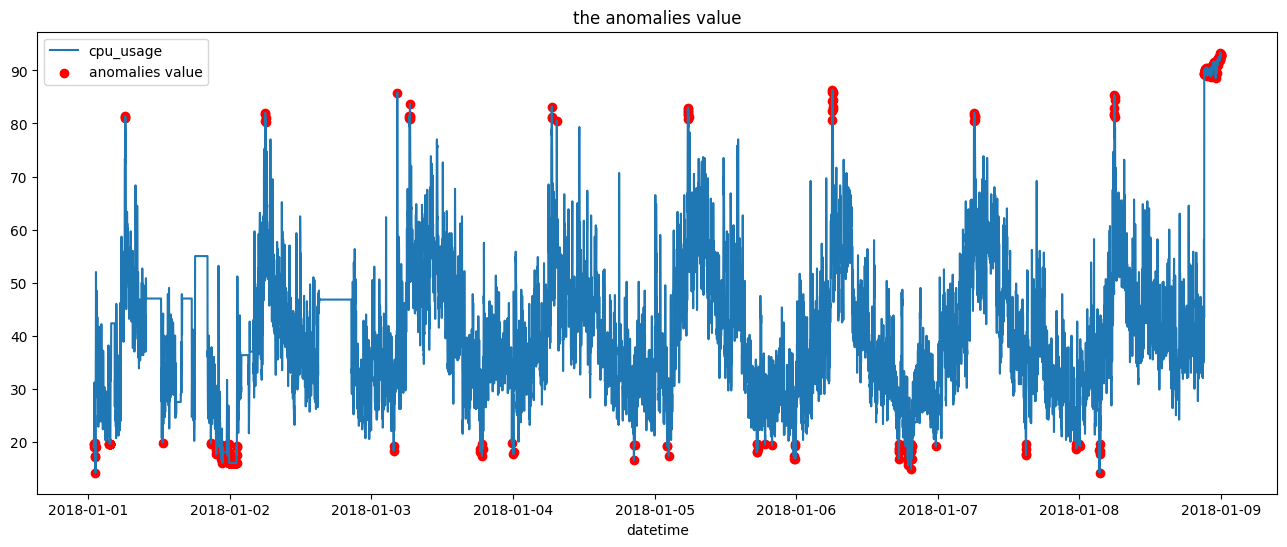

In [18]:
plt.figure(figsize=(16,6))
plt.plot(df.time_step, df.cpu_usage, label='cpu_usage')
plt.scatter(df.time_step[anomaly_indexes], df.cpu_usage[anomaly_indexes], color='red', label='anomalies value')

plt.title('the anomalies value')
plt.xlabel('datetime')
plt.legend(loc='upper left')
plt.show()